In [2]:
%pylab inline
from jax.scipy.ndimage import map_coordinates
from constant import * 
import warnings
from jax import jit, partial, random, vmap
from tqdm import tqdm
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [3]:
cgrid = np.load("cgrid.npy")
bgrid = np.load("bgrid.npy")
kgrid = np.load("kgrid.npy")
hgrid = np.load("hgrid.npy")
agrid = np.load("agrid.npy")


# define approximation of fit
def actions(t, w,n,m,s,e,o):
    c = map_coordinates(cgrid[:,:,:,:,:,:,t],jnp.vstack((w/scaleW,n/scaleN,m/scaleM,s,e,o)), order = 1, mode = 'nearest')
    b = map_coordinates(bgrid[:,:,:,:,:,:,t],jnp.vstack((w/scaleW,n/scaleN,m/scaleM,s,e,o)), order = 1, mode = 'nearest')
    k = map_coordinates(kgrid[:,:,:,:,:,:,t],jnp.vstack((w/scaleW,n/scaleN,m/scaleM,s,e,o)), order = 1, mode = 'nearest')
    h = map_coordinates(hgrid[:,:,:,:,:,:,t],jnp.vstack((w/scaleW,n/scaleN,m/scaleM,s,e,o)), order = 1, mode = 'nearest')
    a = map_coordinates(agrid[:,:,:,:,:,:,t],jnp.vstack((w/scaleW,n/scaleN,m/scaleM,s,e,o)), order = 1, mode = 'nearest')
    a = (a > 0.6)*1 + (a <= 0.6)*0
    h = o*H + (1-o)*h
    return jnp.column_stack((c,b,k,h,a))

#Define the earning function, which applies for both employment, 27 states
@partial(jit, static_argnums=(0,))
def y(t, x):
    '''
        x = [w,n,m,s,e,o]
        x = [0,1,2,3,4,5]
    '''
    if t <= T_R:
        return detEarning[t] * (1+gGDP[jnp.array(x[3], dtype = jnp.int8)]) * x[4] + (1-x[4]) * welfare
    else:
        return detEarning[-1]
    
#Earning after tax and fixed by transaction in and out from 401k account 
@partial(jit, static_argnums=(0,))
def yAT(t,x):
    yt = y(t, x)  
    if t <= T_R:
        # yi portion of the income will be put into the 401k if employed
        return (1-tau_L)*(yt * (1-yi))*x[4] + (1-x[4])*yt
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        return (1-tau_R)*yt + x[1]*Dn[t]
    
#Define the evolution of the amount in 401k account 
@partial(jit, static_argnums=(0,))
def gn(t, x, r = r_bar):
    if t <= T_R:
        # if the person is employed, then yi portion of his income goes into 401k 
        n_cur = x[1] + y(t, x) * yi * x[4]
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        n_cur = x[1] - x[1]*Dn[t]
        # the 401 grow as the same rate as the stock 
    return (1+r)*n_cur

In [4]:
@partial(jit, static_argnums=(0,))
def transition(t,a,x):
    '''
        Input:
            x = [w,n,m,s,e,o]
            x = [0,1,2,3,4,5]
            a = [c,b,k,h,action]
            a = [0,1,2,3,4]
        Output:
            w_next
            n_next
            m_next
            s_next
            e_next
            o_next
            
            prob_next
    '''
    nA = a.shape[0]
    s = jnp.array(x[3], dtype = jnp.int8)
    e = jnp.array(x[4], dtype = jnp.int8)
    # actions taken
    b = a[:,1]
    k = a[:,2]
    action = a[:,4]
    w_next = ((1+r_b[s])*b + jnp.outer(k,(1+r_k)).T).T.flatten().repeat(2)
    n_next = gn(t, x)*jnp.ones(w_next.size)
    s_next = jnp.tile(jnp.arange(nS),nA).repeat(nE)
    e_next = jnp.column_stack((e.repeat(nA*nS),(1-e).repeat(nA*nS))).flatten()
    # job status changing probability and econ state transition probability
    pe = Pe[s, e]
    ps = jnp.tile(Ps[s], nA)
    prob_next = jnp.column_stack(((1-pe)*ps,pe*ps)).flatten()
    
    # owner
    w_next_own = w_next + (action*(H*pt - x[2])).repeat(nS*nE)
    m_next_own = ((1-action)*x[2]*Dm[t]).repeat(nS*nE)
    o_next_own = (x[5] - action).repeat(nS*nE)
    # renter
    if t <= t_high:
        w_next_rent = w_next
        m_next_rent = (action*H*pt*0.8).repeat(nS*nE)
        o_next_rent = action.repeat(nS*nE)
    else:
        w_next_rent = w_next
        m_next_rent = np.zeros(w_next.size)
        o_next_rent = np.zeros(w_next.size)
    w_next = x[5] * w_next_own + (1-x[5]) * w_next_rent
    m_next = x[5] * m_next_own + (1-x[5]) * m_next_rent
    o_next = x[5] * o_next_own + (1-x[5]) * o_next_rent   
    return jnp.column_stack((w_next,n_next,m_next,s_next,e_next,o_next,prob_next))

In [105]:
num = 1000000
# historical state and action value 
ws = np.zeros((T_max-T_min-1,num))
ns = np.zeros((T_max-T_min-1,num))
ms = np.zeros((T_max-T_min-1,num))
es = np.zeros((T_max-T_min-1,num))
ss = np.zeros((T_max-T_min-1,num))
os = np.zeros((T_max-T_min-1,num))
cs = np.zeros((T_max-T_min-1,num))
bs = np.zeros((T_max-T_min-1,num))
ks = np.zeros((T_max-T_min-1,num))
hs = np.zeros((T_max-T_min-1,num))

'''
    x = [w,n,m,s,e,o]
    x = [5,0,0,0,0,0]
'''

from jax import random

def simulation(key):
    x = [5, 0, 0, 0, 0, 0]
    path = []
    move = []
    for t in range(T_min, T_max-1):
        _, key = random.split(key)
        a = actions(t, x[0],x[1],x[2],x[3],x[4],x[5])
        xp = transition(t,a,x)
        p = xp[:,-1]
        x_next = xp[:,:-1]
        x = x_next[random.choice(a = nS*nE, p=p, key = key)]
        path.append(x)
        move.append(a[0])
    return jnp.array(path), jnp.array(move)

In [106]:
%%time
# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)

CPU times: user 4min 42s, sys: 2min 13s, total: 6min 55s
Wall time: 1min 24s


In [107]:
# x = [w,n,m,s,e,o]
# x = [0,1,2,3,4,5]
ws = Paths[:,:,0].T
ns = Paths[:,:,1].T
ms = Paths[:,:,2].T
ss = Paths[:,:,3].T
es = Paths[:,:,4].T
os = Paths[:,:,5].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T

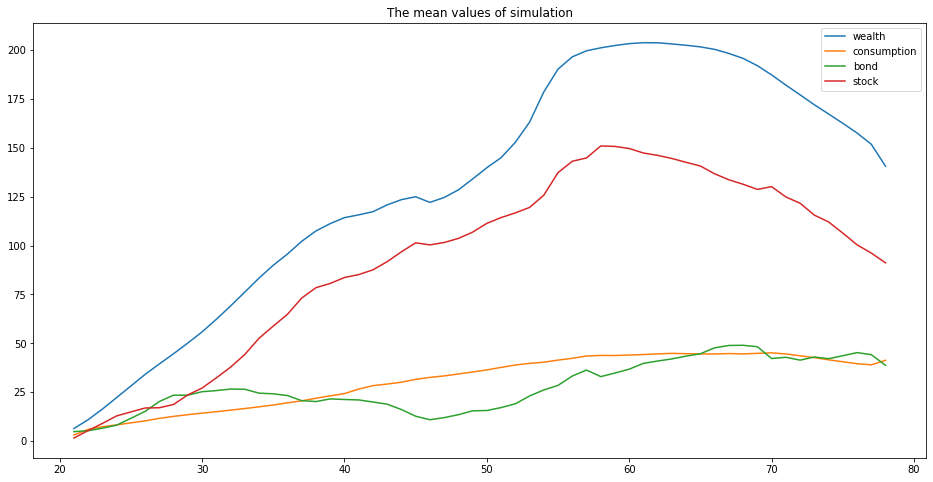

In [108]:
plt.figure(figsize = [16,8])
plt.title("The mean values of simulation")
plt.plot(range(21, T_max-1 + 20), ws.mean(axis = 1)[:-1], label = "wealth")
plt.plot(range(21, T_max-1 + 20),cs.mean(axis = 1)[:-1], label = "consumption")
plt.plot(range(21, T_max-1 + 20),bs.mean(axis = 1)[:-1], label = "bond")
plt.plot(range(21, T_max-1 + 20),ks.mean(axis = 1)[:-1], label = "stock")
# plt.plot((hs*pr).mean(axis = 1)[:-1], label = "housing")
plt.legend()

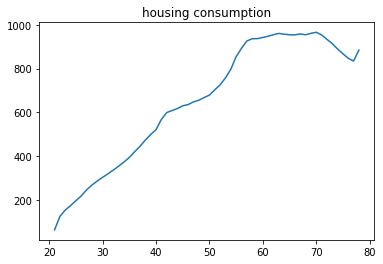

In [109]:
plt.title("housing consumption")
plt.plot(range(21, T_max-1 + 20),(hs).mean(axis = 1)[:-1], label = "housing")

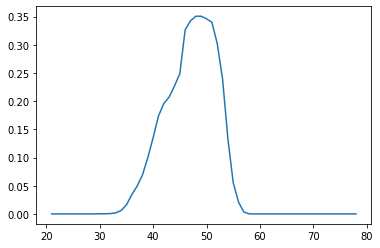

In [112]:
plt.plot(range(21, T_max-1 + 20),(os).mean(axis = 1)[:-1], label = "owning")